In [8]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
from itertools import islice 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import sys
from GenerateConnectedComps import ConnecProbability
sys.path.insert(0, "/data/u934/service_imagerie/v_kapoor/anaconda2/bin/PyImage/utils")
from tifffile import imread
from csbdeep.utils import Path, normalize
from skimage.segmentation import find_boundaries, relabel_sequential
from csbdeep.io import save_tiff_imagej_compatible
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap, draw_polygons, sample_points,fill_label_holes
from stardist import Config, StarDist
import skimage
import scipy
from Normalize import Path,normalizeMinMax, fill_label_holes, save_tiff_imagej_compatible
from skimage import measure
from skimage import filters
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu
from skimage.exposure import rescale_intensity
from scipy import ndimage
np.random.seed(6)
lbl_cmap = random_label_cmap()

# Specify the Source and Target directory for reading and writing XYT shape images, the directory of the models and the model name

In [9]:
SourceDir = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/test3D/'
TargetDir = '/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/results3D/Ray256/'
ModelName = 'StemCell256Rays'
ModelDirectory = '../models/Curiemodels'

Read the files in the current directory and print the total number of files to be segmented. Based upon the model of your choice also specify the number of rays used in the startdist model while doing the training. Also specify the threshold value for probability value.

In [10]:
Path = os.path.join(SourceDir, '*.tif')
X = sorted(glob.glob(Path))
X = list(map(imread,X))
Names = glob.glob(Path)

axes = 'TYX'


thresh = 0.2
nrays = 256

print('Total number of images to be segmented = ', len(X))
print('Image size = ', X[0].shape)


Total number of images to be segmented =  2
Image size =  (73, 512, 512)


Initialize the Stardist model, after we get the labeled image we remove the small labels below a certain size which is 400 pixels by default but is changable. 

In [11]:
model = StarDist(None, name = ModelName, basedir = ModelDirectory )

Loading network weights from 'weights_best.h5'.


In [12]:
def ApplyAll(model, img, timerange, minsize=400):
    
    for j in range(timerange):
      smallimg = img[j,:,:]
      smallprob, smalldist = model.predict(smallimg)
      smallconneclabels = ConnecProbability(smallprob, minsize)  
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=thresh)
      smalllabels = polygons_to_label(smallcoord,smallprob,smallpoints)
      #Remove the small labels
      smalllabels = remove_small_objects(smalllabels, min_size=minsize, connectivity=4, in_place=False)
      smalllabels, forward_map, inverse_map = relabel_sequential(smalllabels)
      
      
      #Stack up the output image over time
      prob[j,:,:] = smallprob[:,:] 
      labels[j,:,:] = smalllabels[:,:]
      conneclabels[j,:,:] = smallconneclabels[:,:]
      
        
    return prob,labels, conneclabels

Apply the model on the input data- Save the UNet output of probability maps and the Labelled images coming out of Stardist after removing the small connected components and normalizing the labelled image for proper viewing as tiff files in Fiji

In [13]:

for i in range(0, len(X)):

 img = normalize(X[i],1,99.8)
 prob = np.array(img)
 labels = np.array(img)
 conneclabels = np.array(img)
 timerange = img.shape[0]
 
 
 ApplyAll(model,img, timerange, 400)   
 save_tiff_imagej_compatible((TargetDir +'StarProbLabels' + ModelName  + os.path.basename(Names[i])) , conneclabels, axes)
 save_tiff_imagej_compatible((TargetDir +'StarLabels'+ ModelName + os.path.basename(Names[i])) , labels, axes)     


 

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]


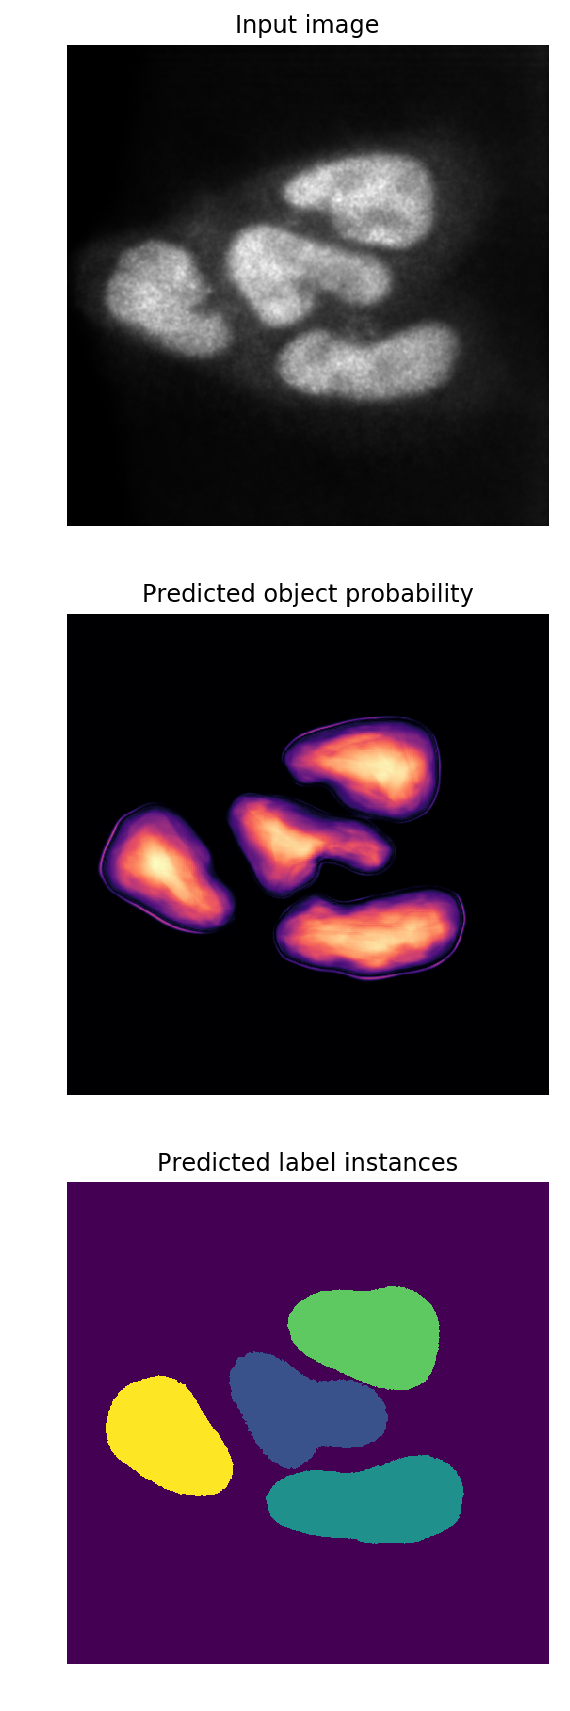

In [14]:
fig, ax = plt.subplots(3,1, figsize=(12,12))
timepoint = 0
imgtime = img[timepoint, :,:]

probtime = prob[timepoint, ...]
labelstime = labels[timepoint, ...]

for a,d,cm,s in zip(ax.flat, [imgtime,probtime,labelstime], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted label instances']):
    a.imshow(d,cmap=cm)
    a.set_title(s)
    a.axis('off')
plt.tight_layout()
None;